May: Bathymetry of Mackenzie Canyon as depicted by the IBCAO_V3_500m_RR and IBCAO_V3_30arcsec_RR.

In [1]:
import  numpy as np
import  os
import  scipy as sc, scipy.io
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from    pyproj import Proj, Geod
import  cartopy.crs as ccrs
import  matplotlib.cm as cm
import colormap_ibcao
import matplotlib.patches as patches

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#### Stereographic: IBCAO_V3_500m_RR

* GMT_version: 4.5.8
* dimensions(sizes): x(11617), y(11617)
* variables(dimensions): float64 x(x), float64 y(y), float32 z(y,x)
* float64 x(x), actual_range: [-2904000.  2904000.], current shape = (11617,)
* float64 y(y), actual_range: [-2904000.  2904000.], current shape = (11617,)
* float32 z(y, x), actual_range: [-5573.01660156  5921.39746094], current shape = (11617, 11617)
* polar stereographic projection

#### Geographic: IBCAO_V3_30arcsec_RR

* GMT_version: 4.5.8 [64-bit]
* dimensions(sizes): x(43201), y(3121)
* variables(dimensions): float64 x(x), float64 y(y), float32 z(y,x)
* Geographic Coordinate System

In [2]:
def get_variables(projection):
    ''' Loads the file for either the Stereographic 
    or Geographic projection of the Arctic Ocean 
    (IBCAO) and returns the file's data for x, y,
    and z. This data can be plotted using the 
    functions below.
    
    Stereographic projection IBCAO_V3_500m_RR.
    Geographic projection IBCAO_V3_30arcsec_RR.
    '''
    if projection == 'S':
        ibcao_grid_name = 'IBCAO_V3_500m_RR.grd'
    elif projection == 'G':
        ibcao_grid_name = 'IBCAO_V3_30arcsec_RR.grd'
    ibcao_grid_dir = '/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid'
    ibcao_grid = os.path.join(ibcao_grid_dir, ibcao_grid_name)
    ibcao_nc = scipy.io.netcdf_file (ibcao_grid)

    x = ibcao_nc.variables['x'][:]
    y = ibcao_nc.variables['y'][:]
    z = ibcao_nc.variables['z'][:]
    return x, y, z

#--------------------------------------------------------------------------------------

def return_boundariesS(x, y, z, xl, xr, yb, yt, case):
    ''' Uses the x, y, and z values from get_variables
    which represent the entire Arctic bathymetry 
    available and extracts a specified region given
    xleft, xright, ybottom, and ytop or a pre-arranged
    case. It returns the xn, yn, and zn of the region.

    Stereographic projection IBCAO_V3_500m_RR.
    '''
    if case == 'region':
        xl=-1800000; xr=-700000; yb=1200000; yt=2000000
    elif case == 'canyon':
        xl=-1600000; xr=-1350000; yb=1560000; yt=1730000
    elif case == 'HS':
        xl=-1630000; xr=-1470000; yb=1580000; yt=1710000
    elif case == None:
        xl=xl; xr=xr; yb=yb; yt=yt
        
    xmin = np.where(x==xl)[0][0]
    xmax = np.where(x==xr)[0][0]
    ymin = np.where(y==yb)[0][0]
    ymax = np.where(y==yt)[0][0]
    xn = x[xmin:xmax]
    yn = y[ymin:ymax]
    zn = z[ymin:ymax, xmin:xmax]
    return xn, yn, zn

#--------------------------------------------------------------------------------------

def return_boundariesG(x, y, z, xl, xr, yb, yt, case):
    ''' Uses the x, y, and z values from get_variables
    which represent the entire Arctic bathymetry 
    available and extracts a specified region given
    xleft, xright, ybottom, and ytop or a pre-arranged
    case. It returns the xn, yn, and zn of the region.
    
    Geographic projection IBCAO_V3_30arcsec_RR.
    '''
    if case == 'region':
        xl=-145; xr=-133; yb=68.6; yt=72.5
    elif case == None:
        xl=xl; xr=xr; yb=yb; yt=yt
        
    xmin = np.where(np.round(x,2)==xl)[0][0]
    xmax = np.where(np.round(x,2)==xr)[0][0]
    ymin = np.where(np.round(y,2)==yb)[0][0]
    ymax = np.where(np.round(y,2)==yt)[0][0]
    xn = x[xmin:xmax]
    yn = y[ymin:ymax]
    zn = z[ymin:ymax, xmin:xmax]
    return xn, yn, zn

#--------------------------------------------------------------------------------------

def plot_mackenzie(fig, ax, xn, yn, zn, plot_type, lines):
    ''' Uses the xn, yn, zn of a reduced region of the 
    Arctic defined by either return_boundaries functions
    and plots the area defined, as pcolor, contour, or 3D.
    '''
    (cmap, norm) = colormap_ibcao.Colormap()
    if plot_type == 'full':
        c = ax.pcolorfast(xn,yn,zn,cmap=cmap)
        fig.colorbar(c)
    if plot_type == 'contour':
        cs = ax.contour(xn,yn,zn,lines,linewidths=2,cmap=cmap)
        ax.clabel(cs, inline=1, fontsize=10)
        cb = fig.colorbar(cs, shrink=0.7)
        for line in cb.lines: 
           line.set_linewidth(12)
        ax.xaxis.tick_top()
    if plot_type=='surface':
        Xn, Yn = np.meshgrid(xn, yn)
        surf = ax.plot_surface(Xn, Yn, zn, cmap=cmap, linewidth=0, rstride=1, cstride=1, antialiased=False)
        fig.colorbar(surf, shrink=0.5)
    return fig, ax

#--------------------------------------------------------------------------------------

def get_information(ax, point, name):
    ''' Labels specific points defined by their
    coordinates with the depth in that region
    and the point's name.
    '''
    x_point = point[0]
    y_point = point[1]
    ax.plot(x_point, y_point, 'ko', markersize=6)
    depth = np.round(z[np.where(y==y_point), np.where(x==x_point)][0][0],2)
    ax.text(x_point, y_point, name + str(depth), fontsize=12)
    return ax

#--------------------------------------------------------------------------------------

def find_distance(p_one, p_two):
    ''' Finds the distance between two points.
    This is used to find the various canyon
    dimensions, such as widths and cross and along
    shore distances.
    '''
    xmax = abs(p_one[0])
    xmin = abs(p_two[0])
    ymax = p_one[1]
    ymin = p_two[1]
    dist = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
    return dist

#--------------------------------------------------------------------------------------

def match_distance(p1_x, p1_y, p2_x, m_slope, ideal):
    ''' Use a reference point [p1_x, p1_y] and the 
    slope of the line to find the second point
    [p2_x, p2_y]. dist gives the length of the line. 
    The goal is to realistic distances found here
    with those set in the idealized canyon domain.
    The ideal case would be for dist = dim leading
    to diff_dist ~ 0.
    '''
    p2_y = p1_y + (m_slope * (p2_x - p1_x))
    dist = find_distance([p1_x, p1_y], [p2_x, p2_y])
    diff = ideal - dist
    return p2_y, dist, diff

### Final distance measurements used in make_mackenzie.ipynb

This map is used to find the dimensions of the canyon. I did this by defining the coordinates of the different key points for the deep ocean, base, break, mouth, mid-canyon, head, coast, and wall. The resolution is 500 m, which is why the coordinates of any of the points are only defined up to the minimum 500 m. The width was found using lines perpendicular to the axis line, given a known x. Once the right points were found given their depths (such as 80 m), the y2 was rounded to the nearest 500 m.

(62681.735776859277, 46456.969337226466, 14142.13562373095)

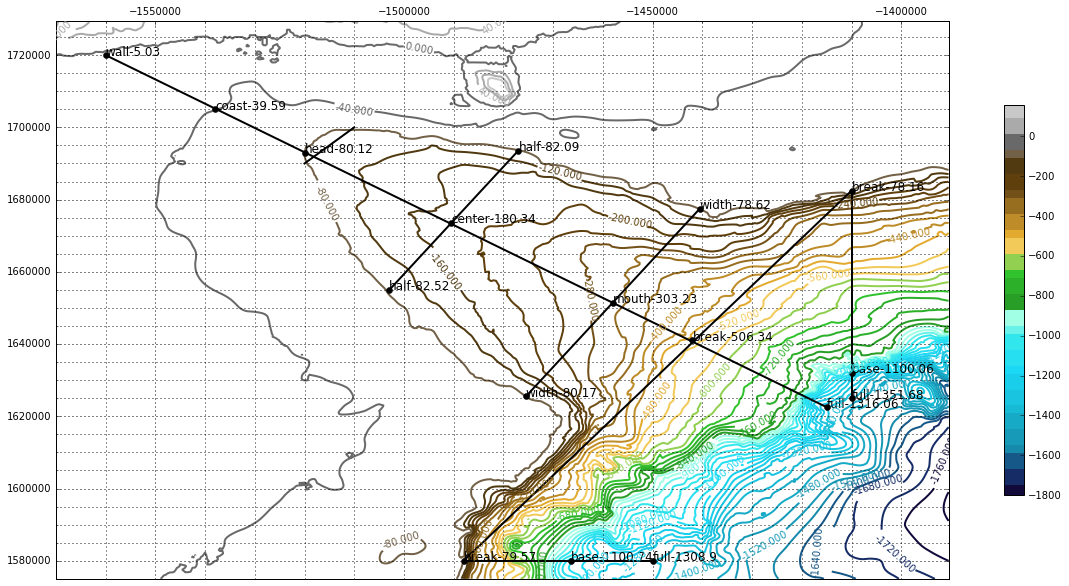

In [3]:
x, y, z = get_variables('S')
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
xl=-1570000; xr=-1390000; yb=1575000; yt=1730000
xn, yn, zn = return_boundariesS(x, y, z, xl, xr, yb, yt, None)
fig, ax = plot_mackenzie(fig, ax, xn, yn, zn, 'contour', 50)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=1.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.9)

# key points used to find canyon dimensions

bkL = [-1488000, 1580000]
fL = [-1450000, 1580000]
bsL = [-1466500, 1580000]
bkR = [-1410000, 1682500]
fR = [-1410000, 1625000]
bsR = [-1410000, 1632000]
bkC = [-1442000, 1641000]
p_top = [-1560000, 1720000]
p_bottom = [-1415000, 1622500]
hL = [-1520000, 1690000]
hR = [-1510000, 1700000]
wlC = [-1560000, 1720000]
cC = [-1490500, 1673500]
fC = [-1415000, 1622500] 
cst = [-1538000, 1705000]
hC = [-1520000, 1693000]
mC = [-1458000, 1651500]

# slope - left
ax.plot([bkL[0], fL[0]], [bkL[1], fL[1]], 'k', linewidth=2)
get_information(ax, bkL, 'break') 
get_information(ax, fL, 'full') 
get_information(ax, bsL, 'base') 

# slope - right
ax.plot([bkR[0], fR[0]], [bkR[1], fR[1]], 'k', linewidth=2)
get_information(ax, bkR, 'break') 
get_information(ax, fR, 'full')
get_information(ax, bsR, 'base') 

# along shelf break
ax.plot([bkR[0], bkL[0]], [bkR[1], bkL[1]], 'k', linewidth=2)
get_information(ax, bkC, 'break')

# inner head
ax.plot([hL[0], hR[0]], [hL[1], hR[1]], 'k', linewidth=2);

# along canyon axis
ax.plot([p_top[0], p_bottom[0]], [p_top[1], p_bottom[1]], 'k', linewidth=2)
get_information(ax, wlC, 'wall') 
get_information(ax, fC, 'full')
get_information(ax, cst, 'coast') 
get_information(ax, hC, 'head')
get_information(ax, mC, 'mouth')
get_information(ax, cC, 'center')

# slope of the canyon axis line and the perpendicular line
m_axis = (p_top[1] - p_bottom[1])/(p_top[0] - p_bottom[0])
m_pend = -1/m_axis 

# canyon widths (at mid-length and mouth)
x1 = cC[0]; y1 = cC[1]
x2 = -1477000
y2 = y1 + (m_pend * (x2 - x1))
w2R = [x2, round(y2/500.0)*500.0]
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2)
get_information(ax, w2R, 'half')

x2 = -1503000
y2 = y1 + (m_pend * (x2 - x1))
w2L = [x2, round(y2/500.0)*500.0]
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2) 
get_information(ax, w2L, 'half')

x1 = mC[0]; y1 = mC[1]
x2 = -1440500
y2 = y1 + (m_pend * (x2 - x1))
wfR = [x2, round(y2/500.0)*500.0]
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2)
get_information(ax, wfR, 'width')

x2 = -1475500
y2 = y1 + (m_pend * (x2 - x1))
wfL = [x2, round(y2/500.0)*500.0]
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2)
get_information(ax, wfL, 'width')

# calculate the dimensons
base_left = find_distance(fL, bsL)
base_right = find_distance(fR, bsR)
break_left = find_distance(fL, bkL)
break_right = find_distance(fR, bkR)
coast = find_distance(fC, cst)
wall = find_distance(fC, wlC)
mouth = find_distance(fC, mC)
length = find_distance(mC, hC)
width_f = find_distance(wfR, wfL)
width_2 = find_distance(w2R, w2L)
width_h = find_distance(hR, hL)
Rcurv = find_distance(mC, cC)
length_new_dist = find_distance(bkC, hC)
length_new = find_distance(fC, bkC)

width_f, width_2, width_h

### Depth Profiles

### Area in Stereographic projection that matches the idealized domain

This map is used to define the domain on the real canyon bathymetry that best matches that of the idealized canyon.

In [4]:
# from make_mackenzie.ipynb
x_wall = 350000.0
adjust = 20000.0 
y_wall = 174731.93755006552 + adjust

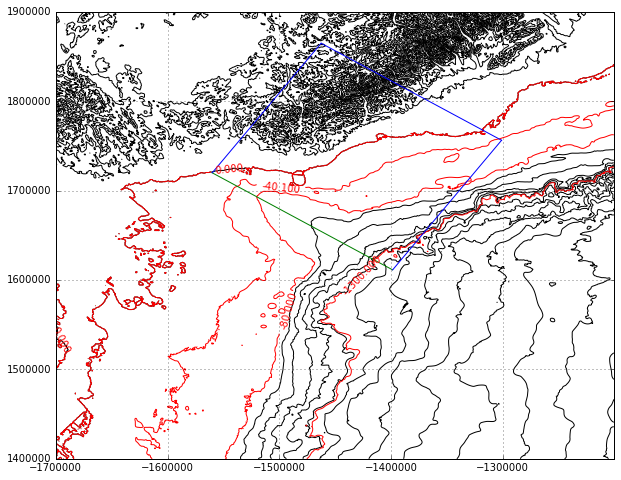

In [5]:
x, y, z = get_variables('S')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
xl=-1700000; xr=-1200000; yb=1400000; yt=1900000
xn, yn, zn = return_boundariesS(x, y, z, xl, xr, yb, yt, None)
ax.contour(xn, yn, zn, 25, colors='k', linestyles='solid')
CS = ax.contour(xn, yn, zn, levels = [-1300, -80, -40.1, 0], colors='r', linestyles='-')
ax.clabel(CS, inline=1); ax.grid()

p1_x0 = p_top[0]
p1_y0 = p_top[1]
p2_x0 = -1398500
m_slope = m_axis
ideal = y_wall
p2_y0, dist0, diff0 = match_distance(p1_x0, p1_y0, p2_x0, m_slope, ideal)
ax.plot([p1_x0, p2_x0], [p1_y0, p2_y0], c='g')

def match_lines(p1_x, p1_y, p2_x_iterate, m_slope, ideal, threshold):
    for x_i in p2_x_iterate:
        y_i, dist_i, diff_i = match_distance(p1_x, p1_y, x_i, m_slope, ideal)
        if abs(diff_i) < threshold:
            p2_x = x_i
            p2_y = y_i
            p2_dist = dist_i
            p2_diff = diff_i
        else:
            pass
    return p2_x, p2_y, p2_dist, p2_diff

p1_x = p2_x0
p1_y = p2_y0
p2_x_iterate = np.arange(p1_x, -1250000, 500)
m_slope = m_pend
ideal = x_wall/2 
threshold = 300.0

p2_xn, p2_yn, distn, diffn = match_lines(p1_x, p1_y, p2_x_iterate, m_slope, ideal, threshold)
ax.plot([p1_x, p2_xn], [p1_y, p2_yn], 'b') 


p1_x = p2_xn
p1_y = p2_yn 
p2_x_iterate = np.arange(p1_x, -1500000, -500)
m_slope = -1/m_pend
ideal = y_wall
threshold = 300

p2_xn, p2_yn, distn, diffn = match_lines(p1_x, p1_y, p2_x_iterate, m_slope, ideal, threshold)
ax.plot([p1_x, p2_xn], [p1_y, p2_yn], 'b') 

p1_x = p2_xn
p1_y = p2_yn 
p2_x_iterate = np.arange(p1_x, -1600000, -500)
m_slope = m_pend; 
ideal = x_wall/2  
threshold = 300

p2_xn, p2_yn, distn, diffn = match_lines(p1_x, p1_y, p2_x_iterate, m_slope, ideal, threshold)
ax.plot([p1_x, p2_xn], [p1_y, p2_yn], 'b') 
